# Batch Convolution Benchmark

Benchmark batches of convolutions (a sequence of audio frames, as in a music file) using different frameworks.

In [1]:
import math

import numba as nb
import numpy as np
from dask import array as da
from dask.distributed import Client
from numba import cuda
from scipy.signal import windows, fftconvolve
from scipy.ndimage import convolve1d

try:  # cupy requires cuda and nvidia gpu
    import cupy as cp
except Exception as e:
    print("cupy did not load")
    cp = np

from util.helper import (
    padlr, realtime, square_and_hann, postprocess_df, compute_error, summary_table,
    title, config as cfg, fmt_all
)

In [2]:
client = Client(processes=False, threads_per_worker=cfg.threads, n_workers=cfg.workers, memory_limit=cfg.mlim)
print(cfg)

Config(cpu_count=8, cpu_freq=3600.0, ram_mb=65469, workers=2, memoffset=90)


## Functions

The following techniques will be benchmarked by performing batches of convolutions.
- `Numba`
    - time domain
    - time domain (parallel)
- `Numpy`
    - time domain
    - freq domain (custom implementation)
- `Scipy`
    - freq domain
- `Cupy`
    - freq domain (GPU)
- `Dask`
    - freq domain (similar to numpy, but chunked across frames)

### Time Domain

In [3]:
def _sumprod(a1, a2, n):
    """multiply/accumulate"""
    acc = np.float32(0.0)
    for i in nb.prange(n):
        acc += a1[i] * a2[i]
    return acc

_sumprod_nb = nb.njit(_sumprod, fastmath=True)

*note: numba finds better parallelization when the loops are all in the same compilation step*

In [4]:
def convolve_realtime(sig, win):
    pass  # placeholder


def convolve_batch_python(sig, win):
    m, n, o = len(win[0]), len(sig[0]), len(sig)
    empt = [0 for _ in range(n)]
    conv = [empt for _ in range(o)]
    norm = sum(win[0])  # cheating: assume all windows the same

    for f in range(o):  # frames
        for t in range(m, n):  # slide
            conv[f][t] = _sumprod(win[f][:], sig[f][t - m : t], m) / norm
    return np.asarray(conv)[:, m - 1:]


@nb.njit(fastmath=True)
def convolve_batch_numba(sig, win):
    m, n, o = win[0].size, sig[0].size, sig.shape[0]
    conv = np.zeros_like(sig)
    norm = win.sum(axis=-1)

    for f in np.arange(o):  # frames
        for t in np.arange(m, n):  # slide
            conv[f, t] = _sumprod_nb(win[f, :], sig[f, t - m : t], m) / norm[f]
    return conv[:, m - 1:]


@nb.njit(fastmath=True, parallel=True)
def convolve_batch_numba_parallel(sig, win):
    m, n, o = win[0].size, sig[0].size, sig.shape[0]
    conv = np.zeros_like(sig)
    norm = win.sum(axis=-1)

    for f in nb.prange(o):  # frames
        for t in nb.prange(m, n):  # slide
            acc, i = 0.0, 0
            for j in nb.prange(t - m, t):  # sum of prod
                acc += win[f, i] * sig[f, j]
                i += 1
            conv[f, t] = acc / norm[f]
    return conv[:, m - 1:]


def convolve_batch_np(sig, win):
    norm = win.sum(axis=-1)
    conv = np.apply_along_axis(lambda row: np.convolve(row, win[0, :], mode="same"), axis=-1, arr=sig)
    return (conv.T / norm).T

### Freq Domain

In [5]:
def convolve_batch_fft_scipy(sig, win):
    norm = win.sum(axis=-1)
    conv = np.apply_along_axis(lambda row: fftconvolve(row, win[0, :], mode="same"), axis=-1, arr=sig)
    return (conv.T / norm).T


def _convolve_fft_np(sig, win):
    pwin = np.pad(win, padlr((sig.size - win.size) / 2, shift=1), mode="constant")
    fwin = np.fft.rfft(pwin)
    fsig = np.fft.rfft(sig)
    c = np.real(np.fft.irfft(fwin * fsig))
    return -1 * c + c.max()


def convolve_batch_fft_np(sig, win):
    norm = win.sum(axis=-1)
    conv = np.apply_along_axis(lambda row: _convolve_fft_np(row, win[0, :]), axis=-1, arr=sig)
    return (conv.T / norm).T


def convolve_batch_fft_dask(sig, win):
    pad = padlr((sig.shape[1] - win.shape[1]) / 2, shift=1)
    pwin = da.pad(win, ((0, 0), pad), mode="constant").rechunk(sig.chunksize)
    fwin = da.fft.rfft(pwin, axis=-1)
    fsig = da.fft.rfft(sig, axis=-1)
    c = da.real(da.fft.irfft(fwin * fsig, axis=-1))
    creal = -1 * c + c.max()
    norm = win.sum(axis=-1)
    return (creal.T / norm).T.compute()


funcs = [
    convolve_realtime, convolve_batch_np, convolve_batch_python,
    convolve_batch_numba, convolve_batch_numba_parallel,
    convolve_batch_fft_scipy, convolve_batch_fft_np, convolve_batch_fft_dask,
]


if cp is not np:
    def _convolve_fft_gpu(sig, win):
        pwin = cp.pad(win, padlr((sig.size - win.size) / 2, shift=1), mode="constant")
        fwin = cp.fft.rfft(pwin)
        fsig = cp.fft.rfft(sig)
        c = cp.real(cp.fft.irfft(fwin * fsig))
        return -1 * c + c.max()
    
    def convolve_batch_fft_gpu_cupy(sig, win):
        norm = win.sum(axis=-1)
        conv = cp.empty_like(sig)
        for i in cp.arange(sig.shape[0]):
            conv[i, :] = _convolve_fft_gpu(sig[i, :], win[0, :])
        return (conv.T / norm).T

    funcs.append(convolve_batch_fft_gpu_cupy)

### Test 

In [6]:
from tqdm import tqdm

results, m, n, fs = [], 2 ** 9, 10, 48_000
for fn in tqdm(funcs[1:]):
    results.append(fn(*square_and_hann(n, fn.__name__, m)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  1.61it/s]


#### Shape and scale

In [7]:
assert len(set(a.shape for a in results)) == 1
assert all(a.max().round(6) == 1.0 for a in results)

#### Error compared to numpy reference

##### Plot helpers

In [8]:
import seaborn as sns
sns.set_style("ticks"), sns.set_palette("pastel")

fnames = [f.__name__ for f in funcs[1:]]
ref, other = results[0], results[:]
plot_kws = {"kind": "line", "estimator": None, "height": 2.4, "aspect": 2.8, "facet_kws": {"sharey": False}}

##### Signal

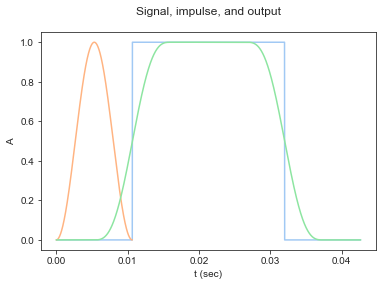

In [9]:
sig, win = square_and_hann(n, "np", m)
t = np.arange(0, sig.shape[1] / fs, 1 / fs)

ax = sns.lineplot(y=sig[0, :], x=t, estimator=None)
ax = sns.lineplot(y=win[0, :], x=t[:win.shape[1]], estimator=None)
ax = sns.lineplot(y=results[0][0, :], x=t, estimator=None)
_ = ax.set_title("Signal, impulse, and output\n"), ax.set_ylabel("A"), ax.set_xlabel("t (sec)")

##### Error compared to reference convolution method

Double check that all implementations are correct so we know that the benchmark numbers are a solid reference.

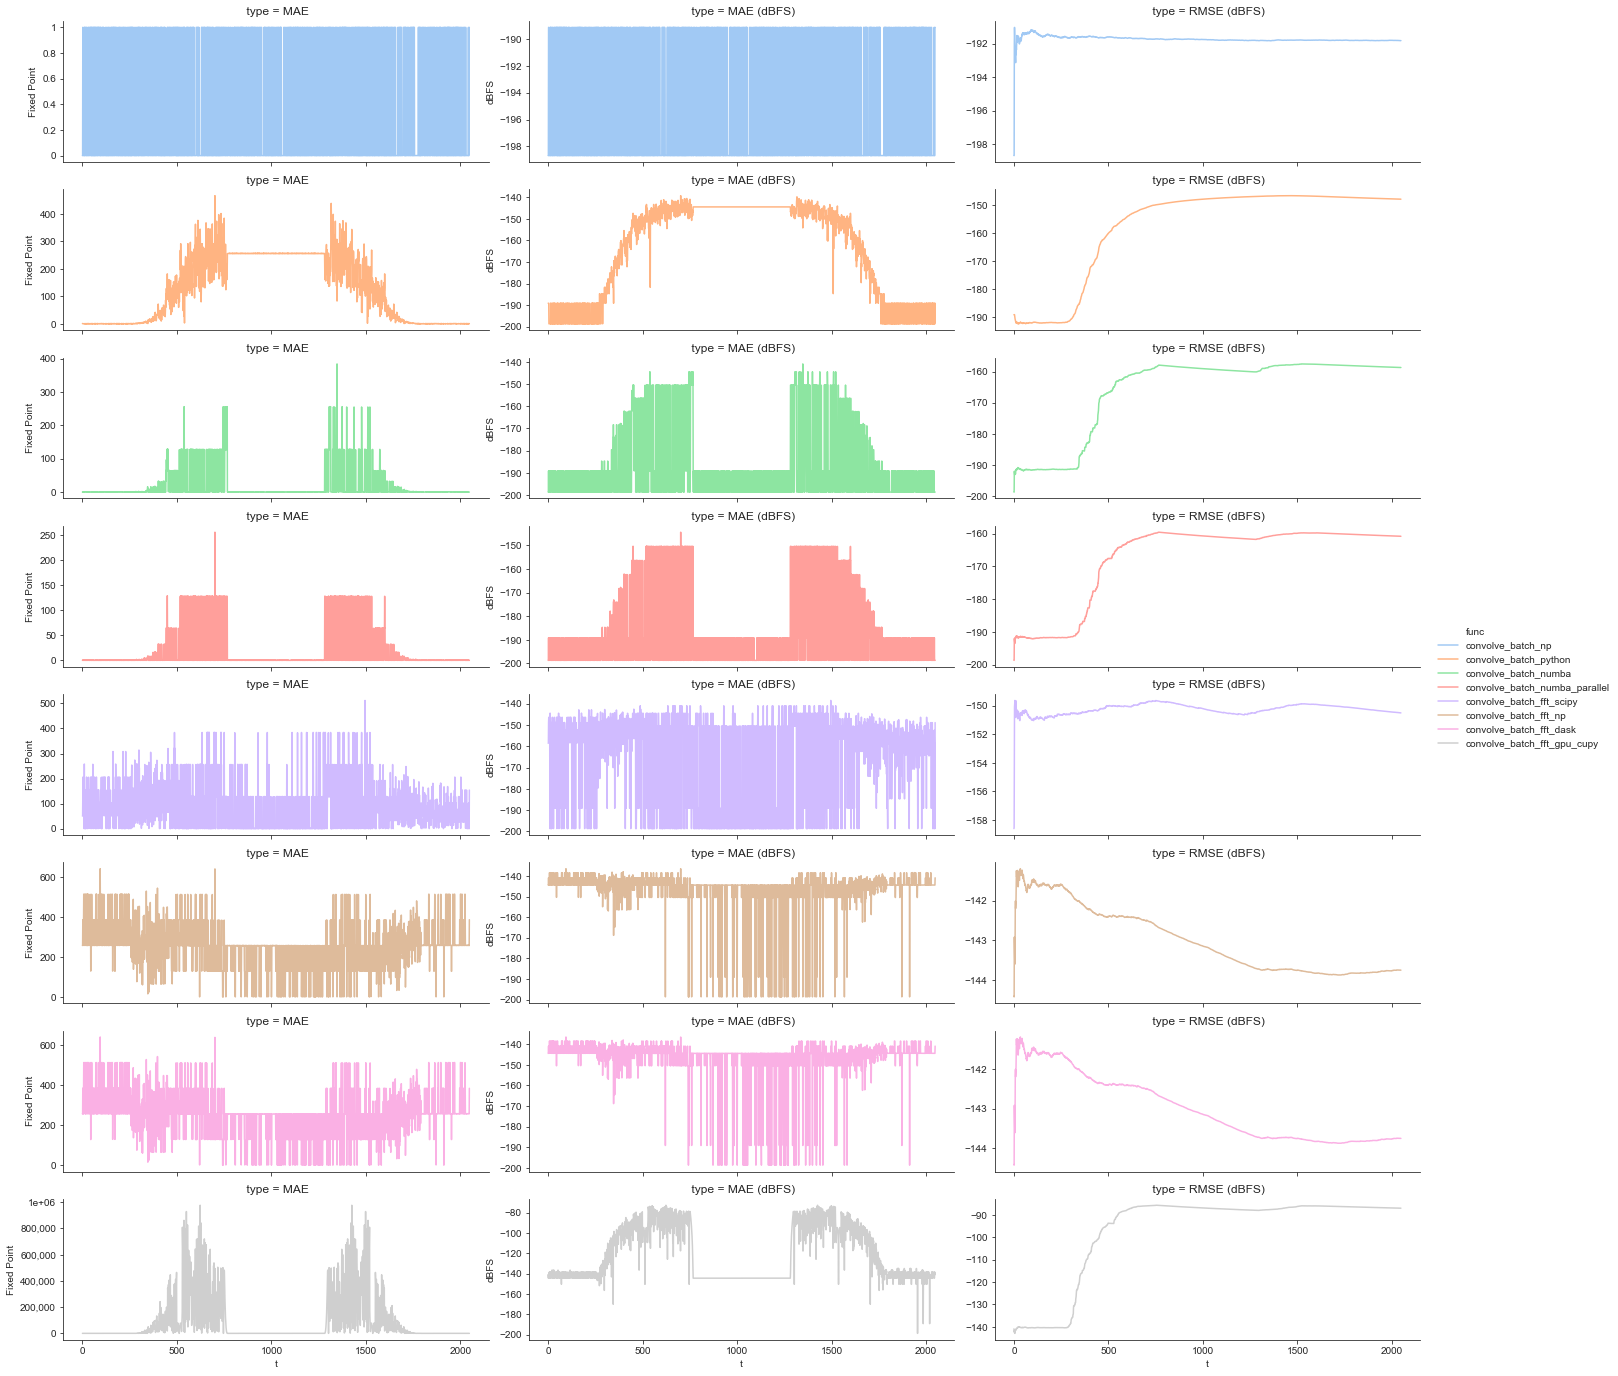

In [10]:
df, dfl = compute_error(ref, other, fnames)
g = sns.relplot(x="t", y="error", row="func", col="type", hue="func", data=df, **plot_kws)
_ = fmt_all(g)

___________________________________________
* The numpy time domain reference error appears randomly at 1 because of dithering
* The GPU error is much higher because it is using 16 bit floats, instead of 32. This was to assist in fitting into device memory.

## Benchmark

The benchmark will include running all algorithms across batches of audio frames ranging in size from 2^0 to 2^14 (1 to 16,384) frames. It will repeat this for frames of size 2^11 and 2^14 (2,048 and 16,384) samples.

This will help assess both scaling in the batch size direction and in the frame size (convolution size) direction.

In [11]:
from util.bench import pd, Timer

t = Timer(funcs, square_and_hann, repeat=1, beg=0, end=14, stop_th=10.0, unit="frames", genkwargs={"framesize": 2 ** 11})
df = t.run(globals())
df = postprocess_df(df, t)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:20<00:00, 34.80s/it]


In [12]:
funcs.remove(convolve_batch_python)  # too slow to bother
t = Timer(funcs, square_and_hann, repeat=1, beg=0, end=14, stop_th=10.0, unit="frames", genkwargs={"framesize": 2 ** 14})
df2 = t.run(globals())
df2 = postprocess_df(df2, t)
df = pd.concat([df, df2])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [06:39<00:00, 73.50s/it]


### Plot Results

#### Log time comparison

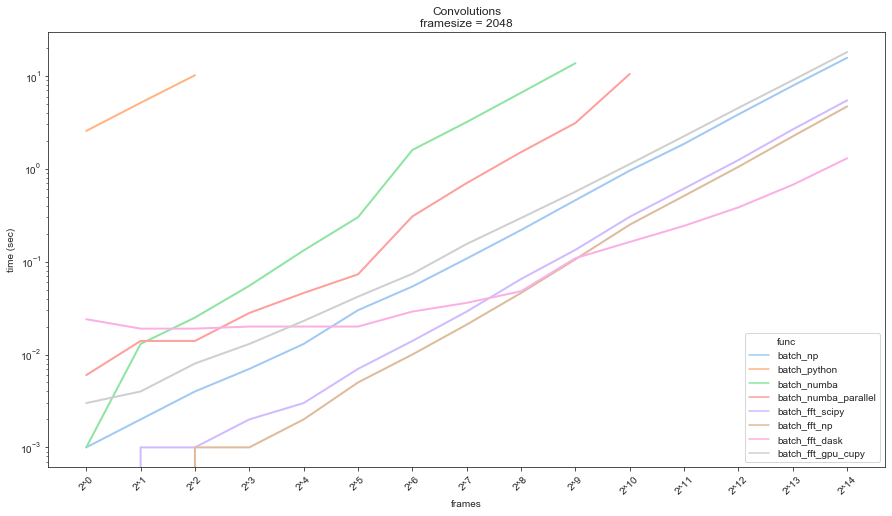

In [13]:
fsize = df.framesize.min()
pdf = df[(df.func != "realtime") & (df.framesize == fsize)]
_ = t.plot_lin(pdf, ys="log", title=title(fsize).strip())

#### Linear time comparison (by domain)


Convolutions
framesize = 2048



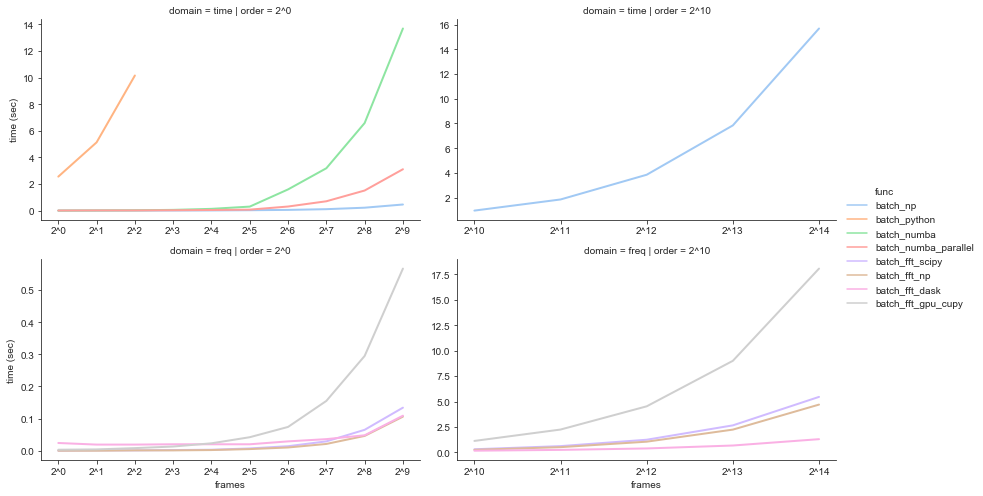

In [14]:
print(title(fsize))
pdf = df[(df.func != "realtime") & (df.framesize == fsize)]
_ = t.plot_facet(pdf, row="domain")

__________________________
Numpy is the only time domain implementation that scales well. It's possible that the Numba version could be improved.

Out of the FFT methods, the GPU is bottlenecked by communication costs between the CPU and GPU (delivery of each frame), and Dask scales the best once communication overhead becomes insignificant compared to the number of frames running in each thread.

#### Linear time comparison (by frame size)


Convolutions
framesize = [ 2048 16384]



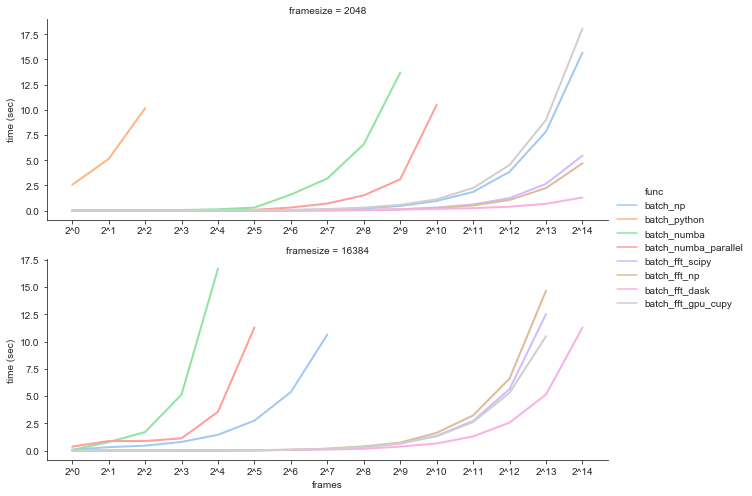

In [15]:
fsize = df.framesize.unique()
print(title(fsize))
pdf = df[df.func != "realtime"]
_ = t.plot_facet(pdf, row="framesize", col=None, hue="func", aspect=2.5)

__________________________________
When the frame size is increased by a factor of 8, the GPU becomes competitive with Dask because the per-frame convolution is much faster, despite the communication overhead.

GPU needs parallelization across frames as well to avoid CPU overhead. This is more complicated as it would require a custom kernel, so not included for now. This is evident by the essentially zero performance penalty as framesize increases.

#### Normalized total samples

x axis = frame size * number of frames

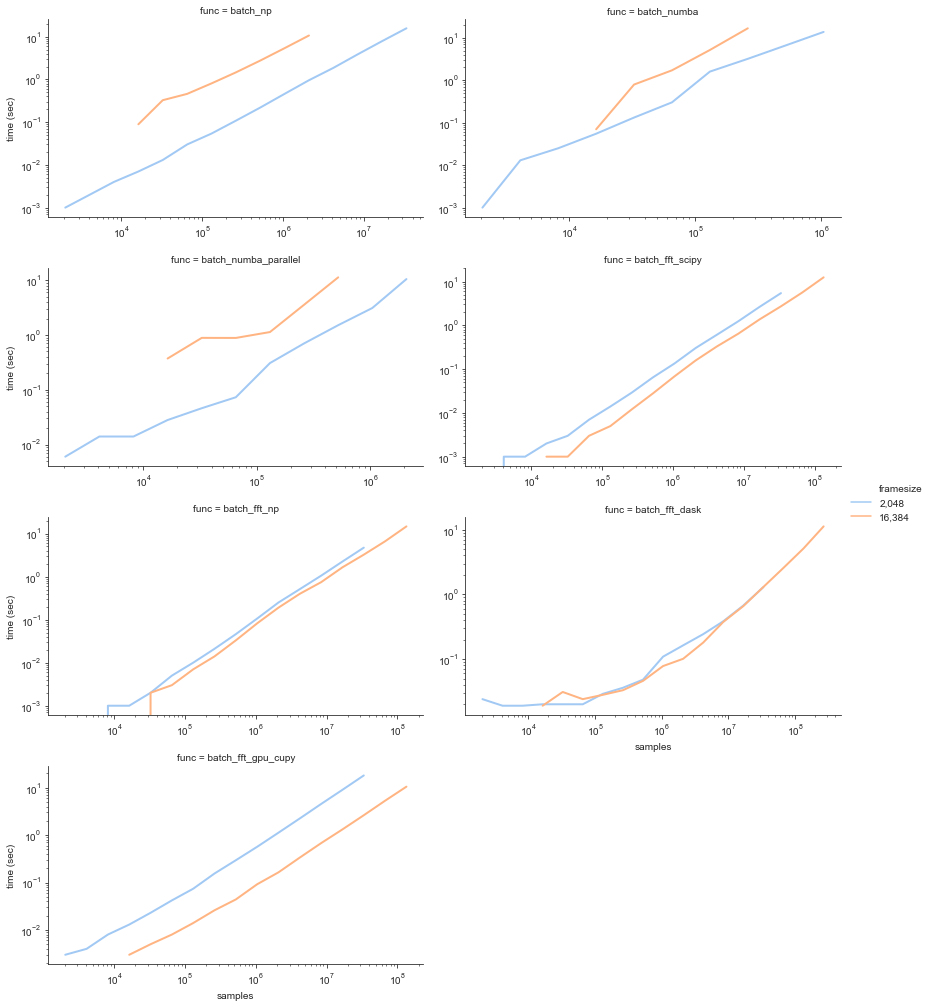

In [20]:
pdf = df[(df.func != "realtime") & (df.func != "batch_python")]
pdf.framesize = pdf.framesize.apply(lambda x: f"{x:,g}")  # categorical
_ = t.plot_facet(pdf, col="func", row=None, x="samples", hue="framesize", xs="log", ys="log", col_wrap=2)

This shows that the Dask-cpu-fft version doesn't care where the samples come from (more frames or larger frames), while the GPU version does better when the extra samples come from a larger frame.
_________________

##### Summary

In [17]:
print(summary_table(df, fs))

                                              time (sec) realtime (sec) 2^n factor of realtime
framesize device domain func                                                                  
2,048     purepy time   batch_python                10.2              0   2               0.0x
          cpu    time   batch_numba                 13.7             22   9               1.6x
                        batch_numba_parallel        10.5             44  10               4.2x
                 freq   batch_fft_dask               1.3            699  14             539.0x
                        batch_fft_np                 4.7            699  14             148.8x
                        batch_fft_scipy              5.5            699  14             128.1x
                 time   batch_np                    15.7            699  14              44.6x
          gpu    freq   batch_fft_gpu_cupy          18.1            699  14              38.7x
16,384    cpu    time   batch_numba               

## Appendix

### A1: Parallelization

In [18]:
convolve_batch_numba_parallel.parallel_diagnostics(level=4)

 
 Parallel Accelerator Optimizing:  Function convolve_batch_numba_parallel, 
<ipython-input-4-234d3c02ce8d> (29)  


Parallel loop listing for  Function convolve_batch_numba_parallel, <ipython-input-4-234d3c02ce8d> (29) 
------------------------------------------------------------|loop #ID
@nb.njit(fastmath=True, parallel=True)                      | 
def convolve_batch_numba_parallel(sig, win):                | 
    m, n, o = win[0].size, sig[0].size, sig.shape[0]        | 
    conv = np.zeros_like(sig)                               | 
    norm = win.sum(axis=-1)                                 | 
                                                            | 
    for f in nb.prange(o):  # frames------------------------| #2
        for t in nb.prange(m, n):  # slide------------------| #1
            acc, i = 0.0, 0                                 | 
            for j in nb.prange(t - m, t):  # sum of prod----| #0
                acc += win[f, i] * sig[f, j]                | 
         